# Baseline evaluation on DeepLabv3 ResNet50
Use this notebook to evaluate the model before training.

## 1. Validation data preparation

In [1]:
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
val_transform = A.Compose([
    A.Resize(768, 1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

In [3]:
from Datasets import Cityscapes

In [4]:
root_dir = 'data'

val_dataset = Cityscapes(root=root_dir, split='val', mode='fine', target_type='labelTrainIds',
                         transforms=val_transform)

In [5]:
val_dataloader = DataLoader(val_dataset, batch_size=24,
                            shuffle=True, num_workers=8, pin_memory=True)

## 2. Inference preparation

In [6]:
import torch
import torch.nn as nn
import torchvision

from torchmetrics import JaccardIndex

# Check for multiple GPUs and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
multi_gpu = torch.cuda.device_count() > 1
if multi_gpu:
    print(f"Using {torch.cuda.device_count()} GPUs")
else:
    print(f"Using device: {device}")

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


Using device: cuda


In [8]:
weights = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=weights)

# Model configuration
model.classifier[4] = nn.Conv2d(256, 20, kernel_size=1)
if model.aux_classifier:
    model.aux_classifier[4] = nn.Conv2d(256, 20, kernel_size=1)
    
# Device configuration
model = model.to(device)

# Loss metric
miou = JaccardIndex(task="multiclass", num_classes=20).to(device)

## 3. Evaluation

In [9]:
model.eval()

with torch.no_grad():
    for inputs, labels in DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=8, pin_memory=True):
        inputs = inputs.to(device)
        labels = labels.to(device).long().squeeze(1)

        outputs = model(inputs)['out']
        predicted = torch.argmax(outputs, dim=1)

        miou.update(predicted, labels)

miou_accuracy = miou.compute().item()
print(f"Validation mIoU: {miou_accuracy}")

Validation mIoU: 0.004608441609889269


## 4. Visualization

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
CITYSCAPES_COLOR_MAP = np.array([
    [128, 64, 128], [244, 35, 232], [70, 70, 70],
    [102, 102, 156], [190, 153, 153], [153, 153, 153],
    [250, 170, 30], [220, 220, 0], [107, 142, 35],
    [152, 251, 152], [0, 130, 180], [220, 20, 60],
    [255, 0, 0], [0, 0, 142], [0, 0, 70],
    [0, 60, 100], [0, 80, 100], [0, 0, 230],
    [119, 11, 32], [255, 255, 255], [0, 0, 0],
    [255, 255, 0], [0, 255, 0], [0, 255, 255],
    [255, 0, 255], [192, 192, 192], [128, 0, 0],
    [128, 128, 0], [0, 128, 0], [128, 0, 128],
    [0, 128, 128], [0, 0, 128], [128, 128, 128],
    [192, 0, 0], [192, 192, 0], [0, 192, 0]
], dtype=np.uint8)

In [14]:
def visualize_segmentation(model, dataset, idx):
    model.eval()
    image, target = dataset[idx]
    
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))['out']
        prediction = output.argmax(1).squeeze(0).cpu().numpy()

    def decode_segmap(segmentation):
        return CITYSCAPES_COLOR_MAP[segmentation]

    segmentation_map = decode_segmap(prediction)

    # Convert the tensor image to a numpy array
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_map)
    plt.title('Segmentation')
    plt.axis('off')

    plt.show()

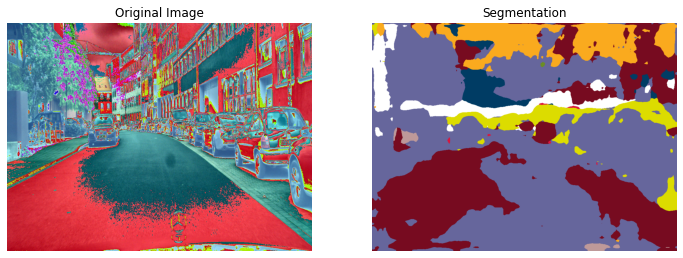

In [15]:
visualize_segmentation(model, val_dataset, idx=400)